EMC Final Project

Nonlinear Dendrite Model


In [1]:
from brian2 import *
%matplotlib inline

#np.random.seed(777777)

I guess a multi dendrites neural model may be implemented by the multicompartment function of Brian2. But, here I implemented it by using usual NeuronGroup function which emulates the dendrites process.

In [2]:
N = 50       #Number of Neurons
J = 6        #Number of Dendrites
lambda_v = 20 * Hz #Leaking rate
r_plus = 1   #Voltage that r rises when spike occurs
omega=100     #Spike voltage. I thought 1 should be OK, but it doesn't work well. I determined it empirically. This is sensitive parameter

lambda_r = 100 * Hz #time constant for low-pass filtered spike: r (lambda_s in EQ.2) This is sensitive parameter.
lambda_d = 10 * Hz #in Fig3 of Boerlin 2013  read-out's decay rate.
v_r=0.75              #Recovery rate Parameter EQ.3. This also affects r much (possibly through 'a' parameter and U_hat )
lambda_s=0.7 * Hz   #Recovery rate Parameter EQ.3

mu = 0#1e-6      #I don't know we need mu. It's written in EQ(S10) but not in Table1
theta=1         #Threshold. I think Theta of Table1 contradicts EQ.(S10).
                #Here, I take Table1. Theta is identical to every neuron (P.5) and it should be diagonal values of U (Table1)
halfN = int(N/2)
halfJ = int(J/2)
Gamma = -1*ones((J,N))
Gamma[:,:] = ((1.0-0.00)*np.random.sample((J,N)) + 0.0)#*np.random.binomial(1,0.7,(J,N))
#Gamma[:,:] = np.random.sample((J,N))
#Gamma[:,:halfN] = ((0.1-0.06)*np.random.sample((J,halfN)) + 0.06)*np.random.binomial(1,0.7,(J,halfN)) #Positive Kernel
#Gamma[:,halfN:] = ((0.06-0.1)*np.random.sample((J,halfN)) - 0.06)*np.random.binomial(1,0.7,(J,halfN)) #Negative kernel
for ii in range(Gamma.shape[1]):   #Gamma should be normalized in Column so that L2 norm equals to theta.
    tmpNorm=sqrt(dot(Gamma[:,ii],Gamma[:,ii]))
    Gamma[:,ii]=Gamma[:,ii]*sqrt(theta)/tmpNorm

A = ones((J,J))
A[:,:] = np.random.sample((J,J))#*np.random.binomial(1,0.8,(J,J))
#A[:,:halfJ] = ((0.1-0.06)*np.random.sample((J,halfJ)) + 0.06)*np.random.binomial(1,0.7,(J,halfJ)) #Positive Kernel
#A[:,halfJ:] = ((0.06-0.1)*np.random.sample((J,halfJ)) - 0.06)*np.random.binomial(1,0.7,(J,halfJ)) #Negative kernel

lambda_x=lambda_s*(1-(v_r)/theta)  #P.4 in the paper. lambda_x should be much smaller than lambda_s.
a=(lambda_s-lambda_x)    #P.5 in the paper
D_init=np.zeros((N,J))
for nn in range(N):
    for jj in range(J):
        D_init[nn,jj]=sum(Gamma[:,nn]*A[:,jj])
#D=A*Gamma
W_init=Gamma
U_hat_init=np.zeros((N,N))
U_init=np.zeros((N,N))
for nn in range(N):          #These calculation are beased on Table1
    for mm in range(N):
        U_hat_init[nn,mm]=a*sum(Gamma[:,nn]*Gamma[:,mm])+ mu*lambda_s/Hz*(nn==mm)
for nn in range(N):
    for mm in range(N):
        U_init[nn,mm]=sum(Gamma[:,nn]*Gamma[:,mm])+ mu*(nn==mm)

In [3]:
#Check the paremeters
tmpNorm=zeros(Gamma.shape[1])
for ii in range(Gamma.shape[1]):   #Gamma should be normalized in Column
    tmpNorm[ii]=sqrt(dot(Gamma[:,ii],Gamma[:,ii]))
print('Gamma columns norm',tmpNorm)
print('Diagonal of U',U_init.diagonal())
print('Diagonal of U_hat',U_hat_init.diagonal())
print('lambda_x should be much smaller than lambda_s. lambda_x:',lambda_x,'  lambda_s:',lambda_s)


Gamma columns norm [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Diagonal of U [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Diagonal of U_hat [0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525
 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525
 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525
 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525 0.525
 0.525 0.525]
lambda_x should be much smaller than lambda_s. lambda_x: 175. mHz   lambda_s: 0.7 Hz


In [4]:
eqs_thalmeier = '''#Neurons with Nonlinear dendrites
dV/dt = -lambda_v*V + D_W_r*Hz + U_hat_r*Hz - U_s*Hz + Hz*(Iext ): 1  #EQ.(4) of the paper
dr/dt= -r * lambda_r : 1                #Low-pass filtered spike
D_W_r : 1                               #From dendrites
U_hat_r : 1                             #From low-pass filtered spike
U_s : 1                                 #From spike
s : 1                                   #Spike
Iext : 1                                # input current
Ifb : 1                                 # feedback current
'''
eqs_dend = '''W_r : 1 #Dendrites simulation
'''
eqs_neur2dend = '''   #Nonlinear dendrite (Neuron to Dendrites)
W_r_post=W * r_pre : 1 (summed)
W:1
'''
eqs_dend2neur = '''   #Nonlinear dendrite (Dendrites to Neurons)
D_W_r_post=D * tanh(W_r_pre) : 1 (summed)
D:1
'''

eqs_synapse_s = '''   #Slow Synapse
U_hat_r_post = U_hat * r_pre : 1 (summed)
U_hat : 1
'''
eqs_synapse_f = '''   #Fast synapse
U_s_post=U * s_pre : 1 (summed)
U : 1
'''

In [5]:
start_scope()
neur = NeuronGroup(N, model=eqs_thalmeier, threshold='V > theta ', method='euler')#, reset='V = V-theta')
#Reset is one of the difficult matters in nonlinear dendrite model. You can use reset function of NeuronGroup, but if so, U matrix cannot be implemented.
dend = NeuronGroup(J, model=eqs_dend, method='euler') #Dendrite emulation neurons. Never fire

#Nonlinear dendrite Synapse(Neurons to Dendrites)
syn_neur2dend = Synapses(neur, dend, model=eqs_neur2dend)
syn_neur2dend.connect()
syn_neur2dend.W=W_init.flatten()

#Nonlinear dendrite Synapse(Dendrites to Neurons)
syn_dend2neur = Synapses(dend, neur, model=eqs_dend2neur)
syn_dend2neur.connect()
syn_dend2neur.D=D_init.flatten()

#Slow Synapse
syn_slow = Synapses(neur, neur, model=eqs_synapse_s, on_pre='r += r_plus')
syn_slow.connect()
syn_slow.U_hat=U_hat_init.flatten()

#Fast Synapse  (Delta function emulation from Adam's code)
syn_fast = Synapses(neur, neur, model=eqs_synapse_f, on_pre={'pre_add': 's += omega',
                                                'pre_sub': 's -= omega'})
syn_fast.connect()
syn_fast.pre_sub.delay = defaultclock.dt
syn_fast.U=U_init.flatten()




In [6]:

drivingFunction = '''F=20*(1.0*i/J)*(abs(t/second)<0.05*i) + 20*((J-1.0*i)/J)*(abs(t/second)>0.05*i)*(abs(t/second)<0.4):1'''#F = -1*sin(14*pi*Hz*t) + 30*cos(28*pi*Hz*t) : 1'''

inneur = NeuronGroup(J,model=drivingFunction)#,events={'custom_event': 't>0*second'})
insyn = Synapses(inneur, neur,
                model='''wi:1 # fixed input weights
                         Iext_post = wi * F_pre : 1 (summed)
                         ''')

#insyn = Synapses(inneur, resevoir,model='wi:1',on_pre='Iext += wi*F_pre',on_event={'pre': 'custom_event'})
insyn.connect()

insyn.wi = Gamma.flatten() #EQ.(4)


In [7]:
#woMon = StateMonitor(outsyn,['wo'],record=True)
#outMon = StateMonitor(outneur,'z',record=True)
inMon = StateMonitor(inneur, 'F',record=True)
resSpikeMon = SpikeMonitor(neur)
resMon = StateMonitor(neur,['V', 'r', 'Iext'], record=True)

In [8]:
duration=500*ms
run(duration)

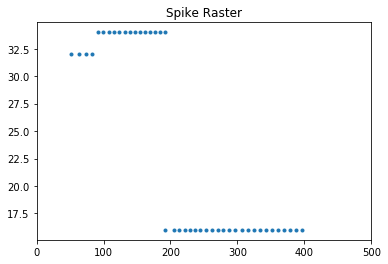

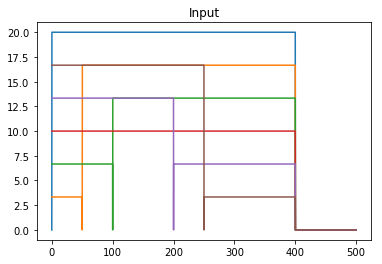

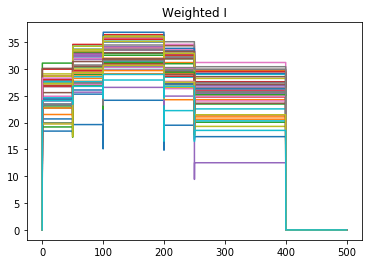

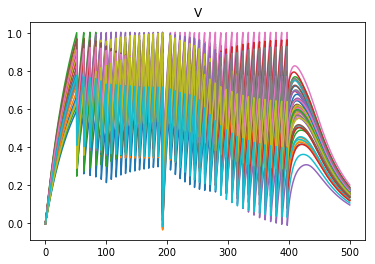

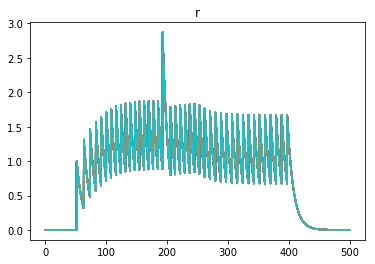

In [9]:
plot(resSpikeMon.t/ms, resSpikeMon.i,'.')
title('Spike Raster')
xlim([0,500])
show()

#plot(outMon.t/ms, outMon.z.flatten())
for i in range(J):
    plot(inMon.t/ms, inMon.F[i])
title('Input')
show()
# Plot Iext (i.e. F times input weight)
for i in range(N):
    plot(resMon.t/ms, resMon.Iext[i])
title('Weighted Input')
show()
for i in range(N):
    plot(resMon.t/ms, resMon.V[i])
title('V')
show()
for i in range(N):
    plot(resMon.t/ms, resMon.r[i])
title('r')
show()